# Portfolio Analysis

## Preparación del entorno de trabajo

In [1]:
# Activate the virtual environment
#Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#.\/venv/Scripts/activate

In [2]:
# Importamos las librerias
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import jinja2 #Controlar las salidas de pandas
import xlsxwriter #Escribir en excel desde Python


## Paso 1: Importación, limpieza y preparación inicial de los datos

En esta etapa se importaron los datos de la fuente de Yahoo Finance. Se han seleccionado los siguientes activos para el periodo de análisis (2020-2025):

- SPY: S&P 500 que se utiliza como Benchmark y proxy de Renta Vaiable
- TLT: Bonos del Tesoro 20+ años que actúa como Refugio y es proxy de Renta Fija
- QQQ: Nasdaq 100 como un activo de alto crecimiento en los últimos años, perteneciente al sector de Tecnología

Para este tipo de análisis es importante considerar un benchmark para medir y comparar el rendimiento de los portafolios y, en la literatura actual, el ETF SPY es el más utilizado. Por otra parte, es usual y útil incluir activos de renta fija, como los bonos del Tesoro de 20 años, como activo de refugio porque históricamente se ha demostrado que existe una correlación negativa con los activos de renta variable. Por último, se ha decidido incluir el Nasdaq 100, el cual representa principalmente el sector de Tecnología y este ha tenido un rápido crecimiento en los últimos años. En resúmen, la construcción de este portafolio cuenta con un componente principal que es el SPY, un activo defensivo el TLT y un activo de crecimiento el QQQ para analizar cómo la diversificación afecta el ratio Sharpe.

Adicionalmente, se realiza la limpieza y preparación de los datos que consiste en:

- Imputar valores faltantes con el último valor disponible
- Eliminar valores faltantes de haber alguno
- Se calcula el retorno diario

Descargando datos de mercado...


[*********************100%***********************]  3 of 3 completed
C:\Users\Beluga\AppData\Local\Temp\ipykernel_18924\3334454893.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


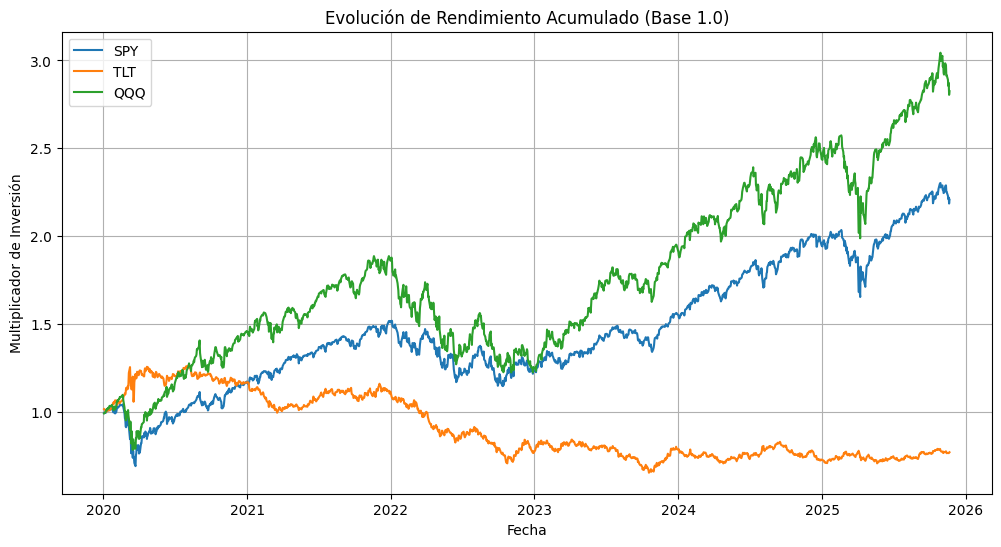

Ticker             QQQ         SPY        TLT
Date                                         
2025-11-17  603.659973  665.669983  89.089996
2025-11-18  596.309998  660.080017  89.059998
2025-11-19  599.869995  662.630005  88.879997
2025-11-20  585.669983  652.530029  89.230003
2025-11-21  590.070007  659.030029  89.500000


In [3]:
# 1. Configuración de parámetros
tickers = ['SPY', 'TLT', 'QQQ']
start_date = '2020-01-01'
end_date = dt.datetime.now()

# 2. Descarga de datos (Automática)
print("Descargando datos de mercado...")
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# 3. Limpieza de datos
# Rellenamos datos faltantes (ffill) y eliminamos filas vacías si las hay
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# 4. Cálculo de Rendimientos
# Rendimiento Diario (Daily Returns)
daily_returns = data.pct_change()

# Rendimiento Acumulado (Cumulative Returns)
# Esto nos permite ver cuánto ha crecido $1 dólar invertido desde el inicio
cumulative_returns = (1 + daily_returns).cumprod()

# 5. Visualización Preliminar (Para validar que tenemos datos)
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.title('Evolución de Rendimiento Acumulado (Base 1.0)')
plt.xlabel('Fecha')
plt.ylabel('Multiplicador de Inversión')
plt.legend()
plt.grid(True)
plt.show()

# 6. Mostrar las últimas filas para verificar
print(data.tail())

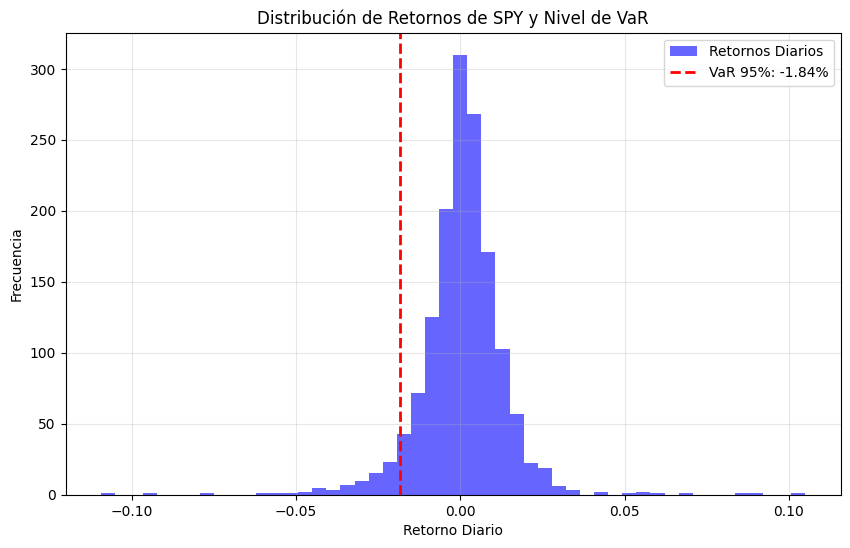

--- TABLA DE INDICADORES (CON VaR) ---


,Retorno Total,CAGR (Anual),Volatilidad,Sharpe Ratio,Max Drawdown,VaR 95% (Diario)
SPY,120.72%,14.40%,20.89%,0.50,-33.72%,-1.84%
TLT,-23.05%,-4.35%,17.23%,-0.48,-48.35%,-1.68%
QQQ,182.53%,19.30%,25.46%,0.60,-35.12%,-2.56%


In [4]:
# Asumimos 252 días de trading al año
dias_trading = 252
risk_free_rate = 0.04  # 4% anual aprox (T-Bills actuales)

# 1. Crear un DataFrame vacío para guardar las métricas
metrics = pd.DataFrame(index=tickers, columns=['Retorno Total', 'CAGR (Anual)', 'Volatilidad', 'Sharpe Ratio', 'Max Drawdown'])

# 2. Cálculo del Retorno Total
metrics['Retorno Total'] = (data.iloc[-1] / data.iloc[0]) - 1

# 3. Cálculo del CAGR (Compound Annual Growth Rate)
# Número de años en la muestra
years = (data.index[-1] - data.index[0]).days / 365.25
metrics['CAGR (Anual)'] = (1 + metrics['Retorno Total'])**(1/years) - 1

# 4. Cálculo de Volatilidad Anualizada
# Desviación estándar diaria * raíz cuadrada de 252
metrics['Volatilidad'] = daily_returns.std() * np.sqrt(dias_trading)

# 5. Cálculo del Ratio de Sharpe
# (Retorno Anual - Tasa Libre de Riesgo) / Volatilidad
metrics['Sharpe Ratio'] = (metrics['CAGR (Anual)'] - risk_free_rate) / metrics['Volatilidad']

# 6. Cálculo del Máximo Drawdown (La parte más compleja)
# Calculamos el pico acumulado hasta la fecha
rolling_max = data.cummax()
# Calculamos la caída porcentual desde ese pico
drawdown = (data / rolling_max) - 1
# Nos quedamos con la caída mínima (la más negativa)
metrics['Max Drawdown'] = drawdown.min()

# --- Formato Visual ---
# Vamos a dar formato de porcentaje para que se vea profesional
pd.options.display.float_format = '{:.2%}'.format

#7. --- CÁLCULO DEL VALUE AT RISK (VaR) ---

# Calculamos el percentil 5 de los retornos diarios
# Esto nos dice: "El 95% de los días, los retornos fueron mejores que este número"
var_95 = daily_returns.quantile(0.05)

# Lo agregamos al DataFrame de métricas
metrics['VaR 95% (Diario)'] = var_95

# --- VISUALIZACIÓN DEL VaR (Gráfico de Distribución) ---
# Este gráfico es ORO para tu presentación en PPT.
# Muestra la distribución de los retornos y dónde corta el VaR.

activo_ejemplo = 'SPY' # Usamos el Nasdaq como ejemplo visual

plt.figure(figsize=(10, 6))
plt.hist(daily_returns[activo_ejemplo], bins=50, alpha=0.6, color='blue', label='Retornos Diarios')
plt.axvline(var_95[activo_ejemplo], color='r', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95[activo_ejemplo]:.2%}')

plt.title(f'Distribución de Retornos de {activo_ejemplo} y Nivel de VaR')
plt.xlabel('Retorno Diario')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Volvemos a mostrar la tabla actualizada
print("--- TABLA DE INDICADORES (CON VaR) ---")
display(metrics.style.format({
    'Retorno Total': '{:.2%}',
    'CAGR (Anual)': '{:.2%}',
    'Volatilidad': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'VaR 95% (Diario)': '{:.2%}' # Nueva columna formateada
}).background_gradient(cmap='RdYlGn', subset=['CAGR (Anual)', 'Sharpe Ratio', 'VaR 95% (Diario)']))

## Optimización del portafolio

1. Ejecutando Optimización de Portafolio...
2. Generando gráfico de Frontera Eficiente...


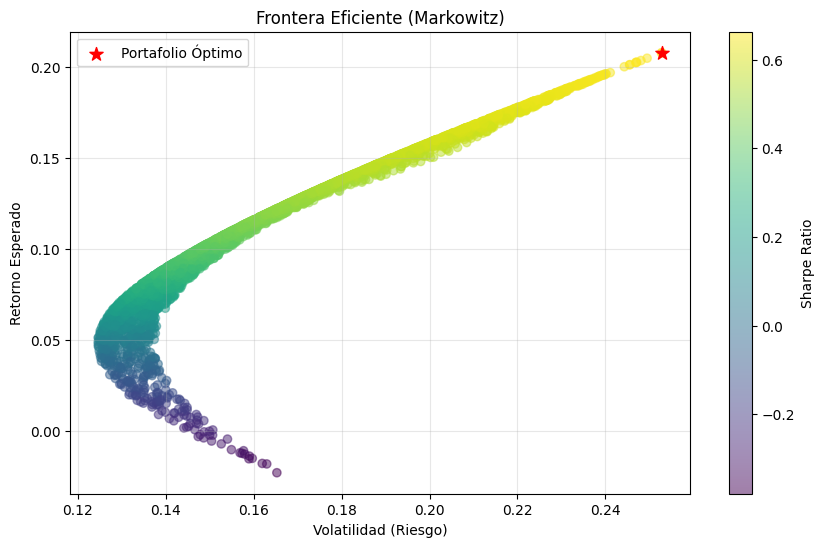

In [7]:
# --- PASO 1: OPTIMIZACIÓN DE PORTAFOLIO (Markowitz) ---
print("1. Ejecutando Optimización de Portafolio...")

# Configuración y Semilla
np.random.seed(42)
num_portafolios = 5000
all_weights = np.zeros((num_portafolios, len(tickers)))
ret_arr = np.zeros(num_portafolios)
vol_arr = np.zeros(num_portafolios)
sharpe_arr = np.zeros(num_portafolios)

# Simulación
for ind in range(num_portafolios):
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[ind, :] = weights
    ret_arr[ind] = np.sum((daily_returns.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    sharpe_arr[ind] = (ret_arr[ind] - risk_free_rate) / vol_arr[ind]

# Obtener el mejor portafolio
max_sharpe_idx = sharpe_arr.argmax()
max_sharpe_return = ret_arr[max_sharpe_idx]
max_sharpe_vol = vol_arr[max_sharpe_idx]
optimal_weights = all_weights[max_sharpe_idx, :]

# Crear un DataFrame para los pesos óptimos (Para ponerlo en Excel)
df_weights = pd.DataFrame(optimal_weights, index=tickers, columns=['Peso Sugerido'])
df_metrics_opt = pd.DataFrame({
    'Métrica': ['Retorno Esperado', 'Volatilidad', 'Sharpe Ratio'],
    'Valor': [max_sharpe_return, max_sharpe_vol, sharpe_arr[max_sharpe_idx]]
})

# --- PASO 2: GENERAR Y GUARDAR EL GRÁFICO DE FRONTERA ---
print("2. Generando gráfico de Frontera Eficiente...")

plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_vol, max_sharpe_return, c='red', s=100, marker='*', label='Portafolio Óptimo')
plt.title('Frontera Eficiente (Markowitz)')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno Esperado')
plt.legend()
plt.grid(True, alpha=0.3)

# ¡TRUCO! Guardamos la imagen en lugar de solo mostrarla
nombre_imagen = 'frontera_eficiente.png'
plt.savefig(nombre_imagen, dpi=100) # Guardamos en alta calidad
#plt.close() # Cerramos para no duplicar en pantalla

## Realizamos la automatización del flujo hacia Excel

In [6]:
# --- PASO 3: CONSTRUCCIÓN DEL REPORTE EXCEL ---
print("3. Construyendo Reporte en Excel...")

nombre_archivo = 'Reporte_Inversion_Completo.xlsx'

with pd.ExcelWriter(nombre_archivo, engine='xlsxwriter') as writer:
    
    workbook = writer.book
    
    # Formatos
    fmt_header = workbook.add_format({'bold': True, 'align': 'center', 'bg_color': '#D7E4BC', 'border': 1})
    fmt_pct = workbook.add_format({'num_format': '0.00%', 'align': 'center'})
    fmt_num = workbook.add_format({'num_format': '0.00', 'align': 'center'})
    
    # ---------------------------------------------------------
    # HOJA 1: RESUMEN KPIs
    # ---------------------------------------------------------
    metrics.to_excel(writer, sheet_name='Resumen KPIs')
    ws_kpis = writer.sheets['Resumen KPIs']
    ws_kpis.set_column('A:A', 15)
    ws_kpis.set_column('B:D', 15, fmt_pct)
    ws_kpis.set_column('E:E', 15, fmt_num)
    ws_kpis.set_column('F:G', 15, fmt_pct)
    
    # ---------------------------------------------------------
    # HOJA 2: OPTIMIZACIÓN (NUEVA HOJA)
    # ---------------------------------------------------------
    ws_opt = workbook.add_worksheet('Optimización Markowitz')
    
    # Escribimos título
    ws_opt.merge_range('A1:C1', 'Asignación de Activos Sugerida', fmt_header)
    
    # Escribimos la tabla de pesos (df_weights)
    ws_opt.write('A2', 'Activo', fmt_header)
    ws_opt.write('B2', 'Peso %', fmt_header)
    
    row = 2
    for ticker, peso in zip(df_weights.index, df_weights['Peso Sugerido']):
        ws_opt.write(row, 0, ticker)           # Nombre del activo
        ws_opt.write(row, 1, peso, fmt_pct)    # Peso en %
        
        # Minigráfico de barras (Data Bar) condicional para ver el peso visualmente
        ws_opt.conditional_format(row, 1, row, 1, {'type': 'data_bar', 'bar_color': '#63C384'})
        row += 1
        
    # Escribimos las métricas del portafolio óptimo al lado
    ws_opt.merge_range('E1:F1', 'Métricas del Portafolio Óptimo', fmt_header)
    ws_opt.write('E2', 'Retorno Esp.')
    ws_opt.write('F2', df_metrics_opt.iloc[0,1], fmt_pct)
    ws_opt.write('E3', 'Volatilidad')
    ws_opt.write('F3', df_metrics_opt.iloc[1,1], fmt_pct)
    ws_opt.write('E4', 'Sharpe')
    ws_opt.write('F4', df_metrics_opt.iloc[2,1], fmt_num)
    
    # INSERTAMOS LA IMAGEN GENERADA
    ws_opt.insert_image('A8', nombre_imagen, {'x_scale': 0.8, 'y_scale': 0.8})
    
    # ---------------------------------------------------------
    # HOJA 3: DATOS HISTÓRICOS (Igual que antes)
    # ---------------------------------------------------------
    data.to_excel(writer, sheet_name='Datos Historicos')
    ws_data = writer.sheets['Datos Historicos']
    fmt_date = workbook.add_format({'num_format': 'dd/mm/yyyy', 'align': 'left'})
    ws_data.set_column('A:A', 12, fmt_date)
    
    # Gráfico de líneas nativo de Excel
    chart = workbook.add_chart({'type': 'line'})
    max_row = len(data)
    for i, ticker in enumerate(tickers):
        col_idx = i + 1
        chart.add_series({
            'name':       ['Datos Historicos', 0, col_idx],
            'categories': ['Datos Historicos', 1, 0, max_row, 0],
            'values':     ['Datos Historicos', 1, col_idx, max_row, col_idx],
            'line':       {'width': 1.0}
        })
    chart.set_title({'name': 'Precios Históricos'})
    chart.set_size({'width': 720, 'height': 400})
    ws_data.insert_chart('E2', chart)

print(f"¡LISTO! Reporte completo generado: {nombre_archivo}")

3. Construyendo Reporte en Excel...
¡LISTO! Reporte completo generado: Reporte_Inversion_Completo.xlsx
